## Import

In [3]:
import pandas as pd
import numpy as np
import gc
import swifter
from tqdm.auto import tqdm
import math
import dask.dataframe as dd
import swifter
import seaborn as sns
import matplotlib.pyplot as plt
import os
import shutil
import random

## Data Preperation

In [43]:
#!rm ../../../data/training -r
#!rm ../../../data/test -r

rm: cannot remove '../../../data/training': No such file or directory
rm: cannot remove '../../../data/test': No such file or directory


### Load Image-Weather Data

In [3]:
df_img_weather = dd.read_csv("../../../data/img_weather_2007_2012.csv")
print(df_img_weather.shape)
df_img_weather.head(2)

(Delayed('int-8e889dca-1bd3-4728-b916-7231b359aae5'), 12)


,id,date,LAT,LON,STN,TEMP,DEWP,SLP,VISIB,WDSP,PRCP,SNDP
0,3873511228,2008-04-04,30,-90,722310,76.8,70.9,1012.7,9.8,10.6,0.0,999.9
1,2402567418,2008-04-04,30,-90,722310,76.8,70.9,1012.7,9.8,10.6,0.0,999.9


In [ ]:
#def get_file_id(filename):
#    return np.int64(filename.split('.')[0])

#get_file_id('234234.txt')

In [ ]:
#df_labels = dd.read_csv('../../../data/labels-all.csv', usecols = ['Image','Label'])
#df_labels.head(2)

In [ ]:
#df_labels['file_id'] = df_labels['Image'].apply(get_file_id, meta=('file_id','int64'))
#df_labels.head(2)

In [13]:
df_labels.compute().shape

(281374, 3)

### Filter for outdoor images

In [15]:
#outdoor_images = df_labels[df_labels['Label']==1]
#print(outdoor_images.compute().shape)
#outdoor_images.head(2)

(281374, 3)


,Image,Label,id
0,1127618657.jpg,1.0,1127618657
1,4571931357.jpg,1.0,4571931357


In [8]:
#df_img_weather = df_img_weather[df_img_weather['id'].isin(outdoor_images['file_id'].compute().values)]
#df_img_weather.head(3)

,id,date,LAT,LON,STN,TEMP,DEWP,SLP,VISIB,WDSP,PRCP,SNDP
15141,4551167383,2010-04-11,43,-4,80210,53.7,49.1,9999.9,4.0,3.8,0.0,999.9
24832,1252040542,2007-08-19,42,-9,80440,66.8,52.9,1021.0,7.5,4.6,0.0,999.9
45558,4637239165,2010-05-24,38,-122,724828,58.9,38.4,1015.2,10.0,9.6,0.0,999.9


In [10]:
df_labels = dd.read_csv('../../../data/meta_all.csv', usecols = ['Image','Label', 'id'])
df_labels.head(2)

,Image,Label,id
0,1127618657.jpg,1.0,1127618657
1,4571931357.jpg,1.0,4571931357


In [18]:
df_img_weather.compute().shape

(10525110, 12)

In [19]:
df_img_weather = df_img_weather[df_img_weather.id.isin(df_labels.id.compute().values)]

In [20]:
df_img_weather.compute().shape

(203010, 12)

### Temperature

(-20.0, 120.0)

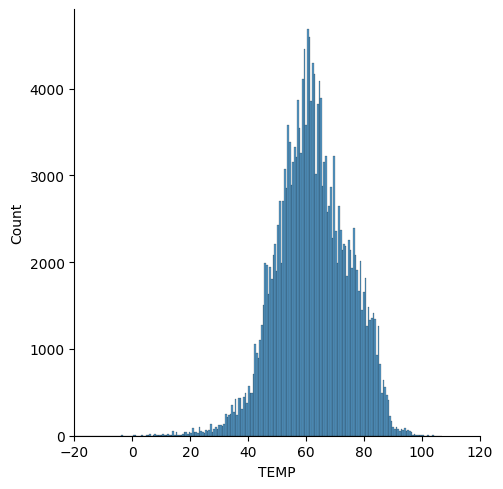

In [21]:
sns.displot(df_img_weather, x="TEMP")
plt.xlim(-20,120)

In [22]:
def get_temperature_class(temperature):
    if temperature== 9999.9:
        return 99
    elif temperature>75:
        return 0
    elif 75>=temperature>65:
        return 1
    elif 65>=temperature>50:
        return 2
    else:
        return 3

In [23]:
df_img_weather['TEMP_class'] = df_img_weather['TEMP'].apply(get_temperature_class, meta=('TEMP_class','int64'))
df_img_weather.head(3)

,id,date,LAT,LON,STN,TEMP,DEWP,SLP,VISIB,WDSP,PRCP,SNDP,TEMP_class
44,1469526786,2007-10-01,44,-80,712700,67.2,53.5,1021.9,999.9,6.3,0.0,999.9,1
883,1466394946,2007-10-01,51,-114,712350,49.1,27.2,9999.9,999.9,9.6,0.0,999.9,3
3188,1399637907,2007-09-15,48,-123,690230,56.2,49.6,1019.3,10.0,3.3,0.0,999.9,2


(0.0, 5.0)

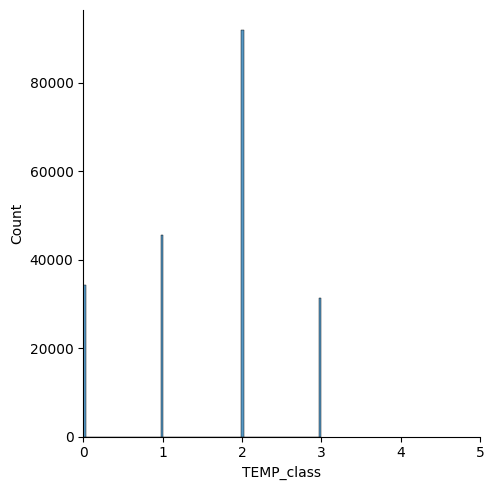

In [24]:
sns.displot(df_img_weather, x="TEMP_class")
plt.xlim(0,5)

### Wind Speed

(0.0, 40.0)

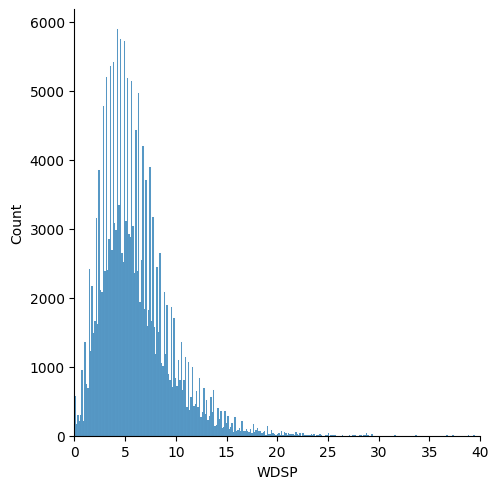

In [25]:
sns.displot(df_img_weather, x="WDSP")
plt.xlim(0,40)

In [26]:
def get_wind_speed_class(speed):
    if speed==999.9:
        return 99
    elif speed>8:
        return 0
    elif 8>=speed>4:
        return 1
    else:
        return 2

In [27]:
df_img_weather['WDSP_class'] = df_img_weather['WDSP'].apply(get_wind_speed_class, meta=('WDSP_class','int64'))
df_img_weather.head(3)

,id,date,LAT,LON,STN,TEMP,DEWP,SLP,VISIB,WDSP,PRCP,SNDP,TEMP_class,WDSP_class
44,1469526786,2007-10-01,44,-80,712700,67.2,53.5,1021.9,999.9,6.3,0.0,999.9,1,1
883,1466394946,2007-10-01,51,-114,712350,49.1,27.2,9999.9,999.9,9.6,0.0,999.9,3,0
3188,1399637907,2007-09-15,48,-123,690230,56.2,49.6,1019.3,10.0,3.3,0.0,999.9,2,2


(0.0, 5.0)

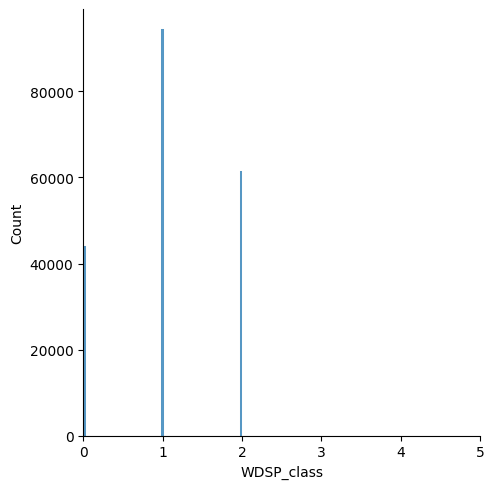

In [28]:
sns.displot(df_img_weather, x="WDSP_class")
plt.xlim(0,5)

### Dew Point

(0.0, 100.0)

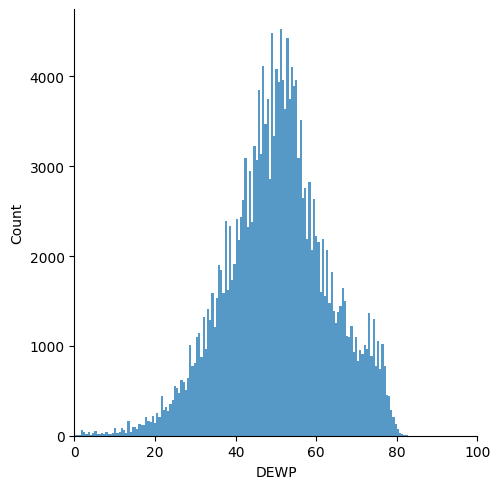

In [29]:
sns.displot(df_img_weather, x="DEWP")
plt.xlim(0,100)

In [30]:
def get_dewp_class(dewp):
    if dewp==9999.9:
        return 99
    elif dewp>60:
        return 0
    elif 60>=dewp>45:
        return 1
    else:
        return 2

In [31]:
df_img_weather['DEWP_class'] = df_img_weather['DEWP'].apply(get_dewp_class, meta=('DEWP_class','int64'))
df_img_weather.head(3)

,id,date,LAT,LON,STN,TEMP,DEWP,SLP,VISIB,WDSP,PRCP,SNDP,TEMP_class,WDSP_class,DEWP_class
44,1469526786,2007-10-01,44,-80,712700,67.2,53.5,1021.9,999.9,6.3,0.0,999.9,1,1,1
883,1466394946,2007-10-01,51,-114,712350,49.1,27.2,9999.9,999.9,9.6,0.0,999.9,3,0,2
3188,1399637907,2007-09-15,48,-123,690230,56.2,49.6,1019.3,10.0,3.3,0.0,999.9,2,2,1


(0.0, 5.0)

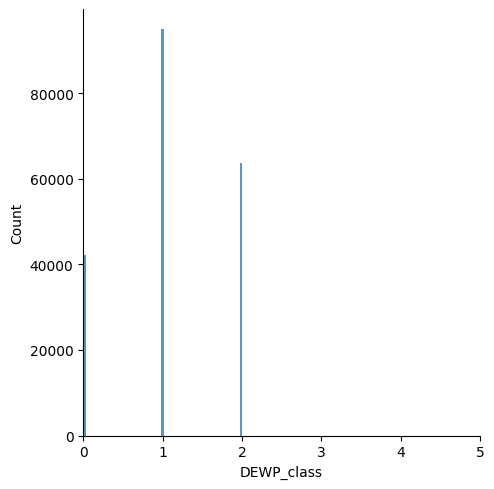

In [32]:
sns.displot(df_img_weather, x="DEWP_class")
plt.xlim(0,5)

### Visibility

(0.0, 40.0)

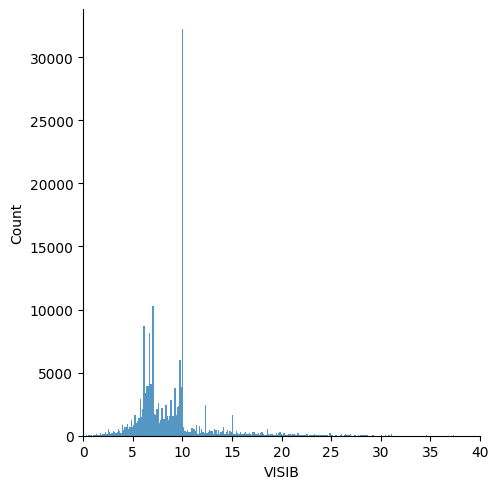

In [33]:
sns.displot(df_img_weather, x="VISIB")
plt.xlim(0,40)

In [34]:
def get_visib_class(visib):
    if visib==999.9:
        return 99
    elif visib>8:
        return 0
    elif 8>=visib>6:
        return 1
    else:
        return 2

In [35]:
df_img_weather['VISIB_class'] = df_img_weather['VISIB'].apply(get_visib_class, meta=('VISIB_class','int64'))
df_img_weather.head(3)

,id,date,LAT,LON,STN,TEMP,DEWP,SLP,VISIB,WDSP,PRCP,SNDP,TEMP_class,WDSP_class,DEWP_class,VISIB_class
44,1469526786,2007-10-01,44,-80,712700,67.2,53.5,1021.9,999.9,6.3,0.0,999.9,1,1,1,99
883,1466394946,2007-10-01,51,-114,712350,49.1,27.2,9999.9,999.9,9.6,0.0,999.9,3,0,2,99
3188,1399637907,2007-09-15,48,-123,690230,56.2,49.6,1019.3,10.0,3.3,0.0,999.9,2,2,1,0


(0.0, 5.0)

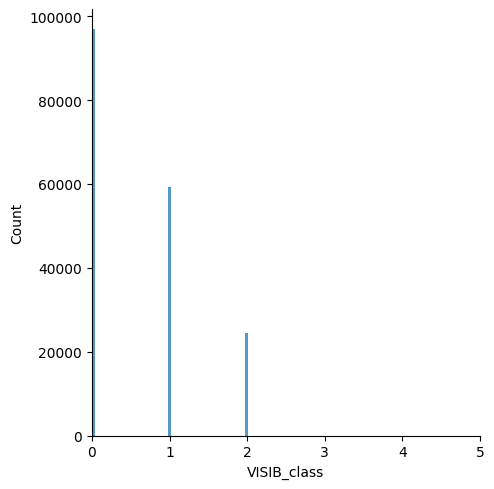

In [36]:
sns.displot(df_img_weather, x="VISIB_class")
plt.xlim(0,5)

### Prepare Images

In [37]:
df_img_weather.head(3)

,id,date,LAT,LON,STN,TEMP,DEWP,SLP,VISIB,WDSP,PRCP,SNDP,TEMP_class,WDSP_class,DEWP_class,VISIB_class
44,1469526786,2007-10-01,44,-80,712700,67.2,53.5,1021.9,999.9,6.3,0.0,999.9,1,1,1,99
883,1466394946,2007-10-01,51,-114,712350,49.1,27.2,9999.9,999.9,9.6,0.0,999.9,3,0,2,99
3188,1399637907,2007-09-15,48,-123,690230,56.2,49.6,1019.3,10.0,3.3,0.0,999.9,2,2,1,0


In [4]:
# Declare class groups and labels
class_groups = ['TEMP_class','WDSP_class', 'DEWP_class', 'VISIB_class']
class_groups_labels = [
    [0,1,2,3],
    [0,1,2],
    [0,1,2],
    [0,1,2]
]         

In [44]:
# Create Empty directory for training and test images
if not os.path.isdir(f"../../../data/training"):
    os.mkdir(f"../../../data/training")
if not os.path.isdir(f"../../../data/test"):
    os.mkdir(f"../../../data/test")
    
for class_group, class_group_labels  in zip(class_groups, class_groups_labels):
    if not os.path.isdir(f"../../../data/training/{class_group}"): 
        os.mkdir(f"../../../data/training/{class_group}")
    if not os.path.isdir(f"../../../data/test/{class_group}"): 
        os.mkdir(f"../../../data/test/{class_group}")        
    
    for label in class_group_labels:
        if not os.path.isdir(f"../../../data/training/{class_group}/{label}"): 
            os.mkdir(f"../../../data/training/{class_group}/{label}")
        if not os.path.isdir(f"../../../data/test/{class_group}/{label}"): 
            os.mkdir(f"../../../data/test/{class_group}/{label}")  

In [45]:
COPIED_FILES = []
SKIPPED_FILES = []
def copy_image_to_training(img_id, class_group, label):
    if label==99:
        return
    if os.path.isfile(f"../../../data/download/1/{img_id}.jpg"):
        shutil.copy(f"../../../data/download/1/{img_id}.jpg", f"../../../data/training/{class_group}/{label}/{img_id}.jpg")
        COPIED_FILES.append(f"../../../data/download/1/{img_id}.jpg")
    else:
        SKIPPED_FILES.append(f"../../../data/download/1/{img_id}.jpg")
        

In [46]:
COPIED_FILES = []
SKIPPED_FILES = []
_ = df_img_weather.apply(lambda x: copy_image_to_training(x['id'], 'TEMP_class', x['TEMP_class']), axis=1, meta=(None, 'object')).compute()
print(len(COPIED_FILES), len(SKIPPED_FILES))

110055 92955


In [47]:
COPIED_FILES = []
SKIPPED_FILES = []
_ = df_img_weather.apply(lambda x: copy_image_to_training(x['id'], 'WDSP_class', x['WDSP_class']), axis=1, meta=(None, 'object')).compute()
print(len(COPIED_FILES), len(SKIPPED_FILES))

108293 91620


In [48]:
COPIED_FILES = []
SKIPPED_FILES = []
_ = df_img_weather.apply(lambda x: copy_image_to_training(x['id'], 'DEWP_class', x['DEWP_class']), axis=1, meta=(None, 'object')).compute()
print(len(COPIED_FILES), len(SKIPPED_FILES))

108867 91750


In [49]:
COPIED_FILES = []
SKIPPED_FILES = []
_ = df_img_weather.apply(lambda x: copy_image_to_training(x['id'], 'VISIB_class', x['VISIB_class']), axis=1, meta=(None, 'object')).compute()
print(len(COPIED_FILES), len(SKIPPED_FILES))

97640 82781


In [50]:
print(SKIPPED_FILES)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [51]:
#Move 10% images for testing
for class_group, class_group_labels  in zip(class_groups, class_groups_labels):
    for label in class_group_labels:
        print(f"Copying {class_group}/{label}")
        files = [f for f in os.listdir(f"../../../data/training/{class_group}/{label}") if os.path.isfile(os.path.join(f"../../../data/training/{class_group}/{label}", f))]
        val_size = len(files)//(100//10)
        val_files = random.sample(files, val_size)
        for file in tqdm(val_files):
            shutil.move(f"../../../data/training/{class_group}/{label}/{file}", f"../../../data/test/{class_group}/{label}/{file}")
        


Copying TEMP_class/0


  0%|          | 0/1983 [00:00<?, ?it/s]

Copying TEMP_class/1


  0%|          | 0/2384 [00:00<?, ?it/s]

Copying TEMP_class/2


  0%|          | 0/4686 [00:00<?, ?it/s]

Copying TEMP_class/3


  0%|          | 0/1951 [00:00<?, ?it/s]

Copying WDSP_class/0


  0%|          | 0/2466 [00:00<?, ?it/s]

Copying WDSP_class/1


  0%|          | 0/5114 [00:00<?, ?it/s]

Copying WDSP_class/2


  0%|          | 0/3249 [00:00<?, ?it/s]

Copying DEWP_class/0


  0%|          | 0/2375 [00:00<?, ?it/s]

Copying DEWP_class/1


  0%|          | 0/4789 [00:00<?, ?it/s]

Copying DEWP_class/2


  0%|          | 0/3722 [00:00<?, ?it/s]

Copying VISIB_class/0


  0%|          | 0/5299 [00:00<?, ?it/s]

Copying VISIB_class/1


  0%|          | 0/3154 [00:00<?, ?it/s]

Copying VISIB_class/2


  0%|          | 0/1310 [00:00<?, ?it/s]

In [5]:
#Copy 10 images from each class to final validation
for class_group, class_group_labels  in zip(class_groups, class_groups_labels):
    for label in class_group_labels:
        print(f"Copying {class_group}/{label}")
        files = os.listdir(f"../../../data/test/{class_group}/{label}")
        val_size = 10
        val_files = random.sample(files, val_size)
        for file in tqdm(val_files):
            shutil.copy(f"../../../data/test/{class_group}/{label}/{file}", f"../../../data/final_test/all/{file}")
        


Copying TEMP_class/0


  0%|          | 0/10 [00:00<?, ?it/s]

Copying TEMP_class/1


  0%|          | 0/10 [00:00<?, ?it/s]

Copying TEMP_class/2


  0%|          | 0/10 [00:00<?, ?it/s]

Copying TEMP_class/3


  0%|          | 0/10 [00:00<?, ?it/s]

Copying WDSP_class/0


  0%|          | 0/10 [00:00<?, ?it/s]

Copying WDSP_class/1


  0%|          | 0/10 [00:00<?, ?it/s]

Copying WDSP_class/2


  0%|          | 0/10 [00:00<?, ?it/s]

Copying DEWP_class/0


  0%|          | 0/10 [00:00<?, ?it/s]

Copying DEWP_class/1


  0%|          | 0/10 [00:00<?, ?it/s]

Copying DEWP_class/2


  0%|          | 0/10 [00:00<?, ?it/s]

Copying VISIB_class/0


  0%|          | 0/10 [00:00<?, ?it/s]

Copying VISIB_class/1


  0%|          | 0/10 [00:00<?, ?it/s]

Copying VISIB_class/2


  0%|          | 0/10 [00:00<?, ?it/s]

In [6]:
from PIL import Image
from torchvision.io import read_image
from torchvision.utils import save_image
import torchvision.transforms as transforms

augment = transforms.TrivialAugmentWide()

def get_files_count(path):
    return len(os.listdir(path))

def get_counts():
    sets = {}
    maxes = {}

    for class_group, class_group_labels  in zip(class_groups, class_groups_labels):
        sets[class_group] = {}
        for label in class_group_labels:
            sets[class_group][label]  = get_files_count(f"../../../data/training/{class_group}/{label}")
        maxes[class_group] = np.max(list(sets[class_group].values()))
    return sets,maxes

def get_dir(group,cls):
    return os.path.join(TRAIN_DIR if group == 'train' else VAL_DIR,cls)

sets,maxes = get_counts()
print(sets,maxes)

for class_group, class_group_labels  in zip(class_groups, class_groups_labels):
    for label in class_group_labels:
        img_count = sets[class_group][label]
        img_max = maxes[class_group]
        
        if img_count != img_max:
            img_dir = f"../../../data/training/{class_group}/{label}"
            listing = os.listdir(img_dir)
            #Check for _ char in filename - we don't want to re-augment our augmented images
            listing = [file for file in listing if "_" not in file]
            for count in tqdm(range(img_count,img_max),desc=f"Augmenting class {label} images"):        
                path = os.path.join(img_dir,random.choice(listing))
                image = read_image(path).cuda()
                #Augment expects a ByteTensor but saving requires a 0-1-scaled FloatTensor, so convert via division
                image_out = augment(image)/255
                save_image(image_out,path.replace(".jpg",f"_{count}.jpg"))

{'TEMP_class': {0: 17848, 1: 21458, 2: 42177, 3: 17568}, 'WDSP_class': {0: 22194, 1: 46026, 2: 29244}, 'DEWP_class': {0: 21382, 1: 43101, 2: 33498}, 'VISIB_class': {0: 47693, 1: 28392, 2: 11792}} {'TEMP_class': 42177, 'WDSP_class': 46026, 'DEWP_class': 43101, 'VISIB_class': 47693}


Augmenting class 0 images:   0%|          | 0/24329 [00:00<?, ?it/s]

Augmenting class 1 images:   0%|          | 0/20719 [00:00<?, ?it/s]

Augmenting class 3 images:   0%|          | 0/24609 [00:00<?, ?it/s]

Augmenting class 0 images:   0%|          | 0/23832 [00:00<?, ?it/s]

Augmenting class 2 images:   0%|          | 0/16782 [00:00<?, ?it/s]

Augmenting class 0 images:   0%|          | 0/21719 [00:00<?, ?it/s]

Augmenting class 2 images:   0%|          | 0/9603 [00:00<?, ?it/s]

Augmenting class 1 images:   0%|          | 0/19301 [00:00<?, ?it/s]

Augmenting class 2 images:   0%|          | 0/35901 [00:00<?, ?it/s]

In [7]:
get_counts()

({'TEMP_class': {0: 42177, 1: 42177, 2: 42177, 3: 42177},
  'WDSP_class': {0: 46026, 1: 46026, 2: 46026},
  'DEWP_class': {0: 43101, 1: 43101, 2: 43101},
  'VISIB_class': {0: 47693, 1: 47693, 2: 47693}},
 {'TEMP_class': 42177,
  'WDSP_class': 46026,
  'DEWP_class': 43101,
  'VISIB_class': 47693})